#Instalaciones Previas

In [1]:
!pip3 install dwave-neal
!pip3 install qubovert
!pip3 install dwave-system

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 80.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for qubovert: filename=qubovert-1.2.5-cp310-cp310-linux_x86_64.whl size=184451 sha256=5295b85825548ce64ce02a4b3d288c64f7a99fc50539b27a767babc03c622190
  Stored in directory: /root/.cache/pip/wheels/ec/78/12/11b3c0c4de9eaa7daa9a91691eca85056f5b3c3ba7fd1bcee2
Successfully built qubovert
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:

import qubovert
import math
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite

import numpy as np
import matplotlib.pyplot as plt
from time import time
import math as math


#Funciones auxiliares y Parámetros


En este apartado definimos diferéntes funciones auxiliares que usaremos a lo largo de la implementación, así como los parámetros para la ejecución del problema

###Funciones auxiliares

*toNumpy*: setrata de una función a la que dado un valor lo transformará a un array de Numpy

In [3]:
#Pasamos a np
def toNumpy(v):
    return np.sqrt(np.sum(v**2))

###Definición de parámetros


***-N***: número de nodos que tendrá el problema.

***-R***: como hemos visto en la modelización del problema en la memoria, las variables pueden tener 3 valores diferentes (0,1,2). Por ello establecemos R=3.

***-Penalización***: es el valor por el que multiplicamos los distintos coeficientes de Lagrange, y que así tomen valores grandes, con el fin de conseguir resultados correctos en la ejecución del problema.

***-lis_r***: se trata de una lista de dimensión R (3) que nos facilitará la imprementación a la hora de establecer las restricciones del problema.

***-lis_n***: al igual que en el caso anterior, una lista que usaremos como índices en los sumatorios de las distintas restricciones.

In [202]:
N = 5
R=3
penalizacion = 2
lis_r = range(R)
lis_n = range(0,N+1)


#Representación del problema

Para crear la creación del problema, creamos distintos puntos que representan los distintos nodos o ciudades que nuestro problema debe recorrer. Como el problema ha de acabar en el punto de salida, igualaremos el último punto al primero.

Los nodos del problema son:
[[0.56102796 0.33801857]
 [0.26347438 0.16601819]
 [0.92718479 0.99925721]
 [0.58969028 0.04777155]
 [0.35941725 0.75452968]
 [0.56102796 0.33801857]]


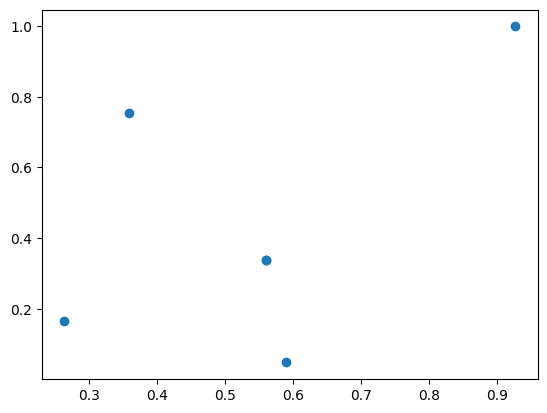

In [203]:
puntos = np.random.rand(N+1,2)
puntos[N]=puntos[0]

print("Los nodos del problema son:")
print(puntos)
plt.plot(puntos[:,0],puntos[:,1],'o')


[[   0.  343.  755.  291.  462.    0.    0.]
 [ 343.    0. 1065.  346.  596.  343.  343.]
 [ 755. 1065.    0. 1009.  618.  755.  755.]
 [ 291.  346. 1009.    0.  743.  291.  291.]
 [ 462.  596.  618.  743.    0.  462.  462.]
 [   0.  343.  755.  291.  462.    0.    0.]
 [   0.  343.  755.  291.  462.    0.    0.]]


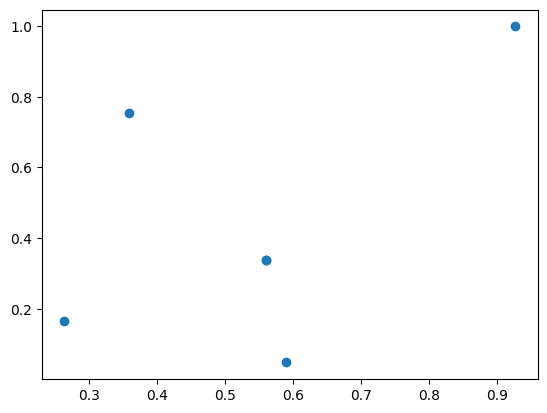

In [204]:
plt.plot(puntos[:,0],puntos[:,1],'o')
distancia = np.zeros((N+2,N+2))
for i in range(N):
    for j in range(i+1,N+1):
        aux  =  toNumpy(puntos[i,:]-puntos[j,:])
        distancia[i,j],distancia[j,i] = aux,aux

for j in range(0,N+1):
    i = N+1
    aux  =  toNumpy(puntos[0,:]-puntos[j,:])
    distancia[i,j],distancia[j,i] = aux,aux
distancia = np.floor(distancia*1000)
print(distancia)

### Matriz distancia.
Se trata de una matriz que guarda las distancia desde un nodo a todos los demás. De este modo, podremos usar esta matriz para obtener el camíno mínimo a recorrer entre todos los puntos. Para una mejor lectura, normalizamos la distancia.

In [205]:
distancia = np.zeros((N+1,N+1))
for i in range(N):
    for j in range(i+1,N+1):
        aux  =  toNumpy(puntos[i,:]-puntos[j,:])
        distancia[i,j],distancia[j,i] = aux,aux
distancia = np.floor(distancia*1000)
print(distancia)


[[   0.  343.  755.  291.  462.    0.]
 [ 343.    0. 1065.  346.  596.  343.]
 [ 755. 1065.    0. 1009.  618.  755.]
 [ 291.  346. 1009.    0.  743.  291.]
 [ 462.  596.  618.  743.    0.  462.]
 [   0.  343.  755.  291.  462.    0.]]


Según la tabla de distancias obtenida anteriormente, obtenemos el camino más corto entre los vecinos cercanos y calculamos la distancia de dicho camino. Es decir tras visitar un nodo $i$, el siguiente nodo a visitar será el $j$ que esté mas cerca de ese primero.

In [206]:
distanciaAux  = np.copy(distancia)
for i in lis_n:
    distanciaAux[i,i] = np.inf
distanciaAux = np.copy(distanciaAux[:-1,:-1])
i = 0
distanciaMin = 0
ordenRecorrido = [i]
for j in range(N):
    distanciaAux[j,0] = np.inf
for cont in range(N-1):
    siguienteDistancia = np.min(distanciaAux[i,:])
    distanciaMin += siguienteDistancia
    sig = np.where(distanciaAux[i,:] == siguienteDistancia)[0][0]
    for j in range(N):
        distanciaAux[j,sig] = np.inf #Actualizamos distancia para que no vuelva a ese nodo
    i = sig
    ordenRecorrido.append(i)
distanciaMin += distancia[ordenRecorrido[-1],0]
#El último nodo es el mismo que el primero.
ordenRecorrido.append(0)

print("El orden recorrido es:", ordenRecorrido)
print("La distancia recorrida es:", distanciaMin)

El orden recorrido es: [0, 3, 1, 4, 2, 0]
La distancia recorrida es: 2606.0


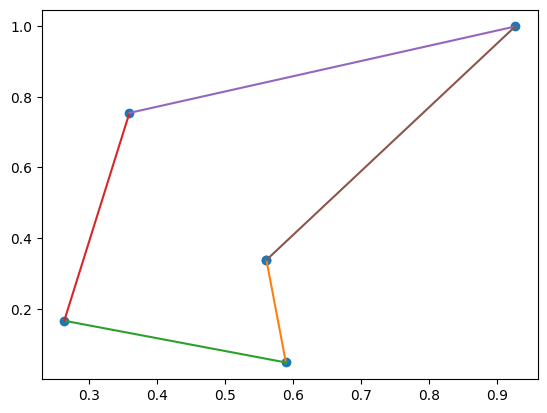

El orden recorrido es: [0, 3, 1, 4, 2, 0]
La distancia recorrida es: 2606.0


In [207]:
plt.plot(puntos[:,0],puntos[:,1],'o')
for i in range(N):
    plt.plot(puntos[(ordenRecorrido[i],ordenRecorrido[i+1]),0],puntos[(ordenRecorrido[i],ordenRecorrido[i+1]),1])
plt.show()
print("El orden recorrido es:", ordenRecorrido)
print("La distancia recorrida es:", distanciaMin)

#Modelo


## Variables del modelo
La clase ***qubovert.QUBO()*** es una implementación de QUBO en Python que proporciona una interfaz conveniente para definir y manipular problemas de optimización en forma de QUBO. Esta clase permite construir la matriz QUBO y realizar diversas operaciones sobre ella.

Como sabemos, nuestras variables son de la forma *f x_{i,j,r}*, entonces usaremos el método **create_var()** para crear las variablesde nuestro problema.

In [208]:
# Creamos las variables del modelo
coef = qubovert.QUBO()

## Variables x_{i,j,r}
for i in lis_n:
    for j in lis_n:
        if not i==j:
            for r in lis_r:
                coef.create_var(f"x_{i}_{j}_{r}")

numVariables = len(lis_n)*len(lis_n)*len(lis_r)
print("Usaremos:", numVariables,"variables")

Usaremos: 108 variables


## Añadimos las restricciones
De acuerdo a las distintas restricciones que hemos definido en la memoria, calculamos los valores que tendrán cada una de nuestras variables de acuerdo a los distintos coeficientes de Lagrnage (también definidos en la memoria).


Restricción 1:
\begin{equation*}
            \sum_{i=0}^{N+1}\sum_{j=0}^{N+1}( \sum_{r_1=0}^{2}\sum_{r_2=0}^{2}\lambda_1 x_{i,j,r_1}x_{i,j,r_2}+\sum_{r=0}^{2}-2\lambda_1 x_{i,j,r})
\end{equation*}

In [209]:
lagrange_1 = distanciaMin*penalizacion
for i in lis_n:
    for j in lis_n:
        if not i==j:
            for r1 in lis_r:
                for r2 in lis_r:
                    coef[(f"x_{i}_{j}_{r1}",f"x_{i}_{j}_{r2}")] += (lagrange_1)
            for r in lis_r:
                    coef[(f"x_{i}_{j}_{r}",)] += -2*(lagrange_1)

Restricción 2:
\begin{equation*}
            \sum_{i=0}^{N}(\sum_{j_1=0}^{N+1}\sum_{j_2=0}^{N+1}\lambda_2 x_{i,j_1,1}x_{i,j_2,1}+\sum_{j=0}^{N}-2\lambda_2 x_{i,j,1})
        \end{equation*}

In [210]:
for i in range(N+1):
    lagrange_2 =penalizacion*np.max(distancia[i,])
    for j in lis_n:
        if not i == j:
            coef[(f"x_{i}_{j}_{1}",)] += -2*lagrange_2
    for j1 in  lis_n:
        if j1 != i:
            for j2 in lis_n:
                if j2!=i:
                    coef[(f"x_{i}_{j1}_{1}",f"x_{i}_{j2}_{1}")]+= lagrange_2

Restricción 3:
\begin{equation*}
            \sum_{j=1}^{N+1}(\sum_{i_1=1}^{N}\sum_{i_2=1}^{N}\lambda_3 x_{i_1,j,1}x_{i_2,j,1}+\sum_{i=1}^{N}-2\lambda_3 x_{i,j,1})
        \end{equation*}

In [211]:
for j in range(1,N+1):
    lagrange_3 = penalizacion*np.max(distancia[:,j])
    for i1 in  lis_n:
        if i1!=j:
            for i2 in lis_n:
                if i2!=j:
                    coef[(f"x_{i1}_{j}_{1}",f"x_{i2}_{j}_{1}")]+= lagrange_3
    for i in range(N+1):
        if i!=j:
            coef[(f"x_{i}_{j}_{1}",)] += -2*lagrange_3

Restrcción 4:
\begin{equation*}
            \sum_{j=0}^{N+1} \lambda_4x_{0,j,2}
        \end{equation*}

In [212]:
lagrange_4 = penalizacion*np.max(distancia[0,j])
for j in lis_n:
    coef[(f"x_{0}_{j}_{2}",)] += lagrange_4

Restrcción 5:
\begin{equation*}
            \sum_{i=0}^{N+1} \lambda_5x_{i,N+1,2}
        \end{equation*}

In [213]:
lagrange_5 = penalizacion*np.max(distancia[i,0])
for i in lis_n:
    coef[(f"x_{i}_{N+1}_{2}",)] += lagrange_5

Restrcción 6:
\begin{equation*}
            \sum_{i=0}^{N+1} \lambda_6x_{i,i}
        \end{equation*}

In [214]:
lagrange_6 = penalizacion*max(np.max(distancia[i,j]),np.max(distancia[j,i]))
for i in lis_n:
    coef[(f"x_{i}_{i}_{1}",)] += lagrange_6

Restrcción 7:
\begin{equation*}
            \sum_{i\neq j} (2\lambda_7 x_{i,j,2}x_{j,i,2}-\lambda_7 x_{i,j,2}-\lambda_7x_{j,i,2})
        \end{equation*}

In [215]:
lagrange_7 = distanciaMin*penalizacion
for i in lis_n:
    for j in lis_n:
        if i!=j:
            coef[(f"x_{i}_{j}_{2}",f"x_{j}_{i}_{2}")] += 2*lagrange_7
            coef[(f"x_{i}_{j}_{2}",)] -= lagrange_7
            coef[(f"x_{j}_{i}_{2}",)] -= lagrange_7

Restrcción 8

\begin{equation*}
        \sum_{i=1}^{N}\sum_{j=1}^{N}\sum_{k=1}^{N} (\lambda_8x_{j,i,2}x_{k,j,2})-(\lambda_8x_{j,i,2}x_{k,i,2})-(\lambda_8x_{k,j,2}x_{k,i,2})+\lambda_8x_{k,i,2}
    \end{equation*}

In [216]:

lagrange_8 = distanciaMin*penalizacion
for i in range(1,N+1):
    for j in range(1,N+1):
        for k in range(1,N+1):
            if i!=j and j!=k and i!=k:
                coef[(f"x_{j}_{i}_{2}",f"x_{k}_{j}_{2}")] += lagrange_8
                coef[(f"x_{j}_{i}_{2}",f"x_{k}_{i}_{2}")] -= lagrange_8
                coef[(f"x_{k}_{j}_{2}",f"x_{k}_{i}_{2}")] -= lagrange_8
                coef[(f"x_{k}_{i}_{2}",)] += lagrange_8



Función objetivo:
\begin{equation}
    \sum_{i=0}^{N+1}\sum_{j=0}^{N+1} \lambda_{obj} x_{i,j,1} d_{i,j}
\end{equation}

In [217]:
lagrange_obj = 1
for i in lis_n:
    for j in lis_n:
        if i!=j:
            coef[(f"x_{i}_{j}_{1}",)] += lagrange_obj*distancia[i,j]

## Ejecución

Para la ejecución del problema, debemos crear primero de todo el modelo cuadrático vinario (BQM) que le pasaremos al *sampler* de *D-Wave*. Este modelo es diccionario tiene como claves cada par de variables y como valores, el valor calculado en el paso anterior.

In [218]:
dwaveDic = {}
for i in coef:
    if len(i) == 1:
        dwaveDic[(i[0],i[0])] = coef[i]
    else:
        dwaveDic[i] = coef[i]

### Annealing Real
En la siguiente ejecución, a diferencia de la anterior, ejecutaremos nuestro problema en un *quantum annealer* físico y no mediante una simulación ( ***DWaveSampler()***). Para poder llevar a cabo esta ejecución necesitamos abstraer elproblema de forma de que el *quantum annealer* sea capaz de manejar.

Un *quantum annealer* tiene una arquitectura de conectividad limitada, lo que significa que solo ciertos pares de qubits están directamente conectados entre sí. Sin embargo, para resolver un problema de optimización general, se requiere una conectividad más amplia entre los qubits.

***EmbeddingComposite*** se encarga de mapear o embeber el problema de optimización en el hardware específico del quantum annealer. Utiliza técnicas de mapeo y enrutamiento para transformar el problema de optimización de un grafo general a un grafo compatible con la conectividad del hardware.

En resumen, al utilizar ***EmbeddingComposite(DWaveSampler())***, estás creando un objeto *sampler* que toma un quantum annealer físico (***DWaveSampler()***) y lo envuelve en ***EmbeddingComposite*** para manejar el mapeo y enrutamiento del problema de optimización en el hardware del *quantum annealer*.

Los parámetros que permite ***EmbeddingComposite()*** son:


*   **-bqm**: El modelo cuadrático binario que se va a muestrear.

*   **-chain_strength**: Establece la fuerza de acoplamiento entre los qubits que representan variables.  Un valor bajo de **chain_strength** puede favorecer la exploración del espacio de soluciones, ya que las cadenas más débiles permiten una mayor flexibilidad para explorar diferentes configuraciones de qubits. Por otro lado, un valor alto de chain_strength puede favorecer la explotación, permitiendo una búsqueda más intensiva de mínimos locales y soluciones óptimas.

*   **-chain_break_method**: Especifica el método o métodos utilizados para resolver las rupturas de cadena. El método por defecto es voto por la mayoría por lo que dejaremos ese.

*   **-chain_break_fraction**: Proporciona información sobre cuántas cadenas se han roto durante el proceso de muestreo antes de obtener las soluciones finales.

*   **-embedding_parameters**: Si se proporciona, estos parámetros se pasan al método de *embedding* como argumentos de palabra clave.

*   **-return_embedding**: Si se establece en *True*, se agrega información sobre el *embedding*, fuerza de acoplamiento de las cadenas, método de resolución de rupturas de cadena y los parámetros de *embedding* al campo ***dimod.SampleSet.info*** del conjunto de muestras devuelto.

*   **-warnings**: Define, si la hay, qué acción de advertencia realizar.

[D-Wave Ocean](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/generated/dwave.system.composites.EmbeddingComposite.sample.html)



In [219]:
TOKEN="DEV-512e056dfd01980d70f3c29a9e1207e80f34783b"

In [257]:
import time
t=time.time()
sampler = EmbeddingComposite(DWaveSampler(token=TOKEN, solver=dict(topology__type='pegasus')))
sampleset = sampler.sample_qubo(dwaveDic, num_reads=5500, return_embedding=True, chain_strength=5000)

print("La solución es: ", (sampleset.first.sample), sampleset.first.energy)
time=time.time()-t

La solución es:  {'x_0_1_0': 1, 'x_0_1_1': 0, 'x_0_1_2': 0, 'x_0_2_0': 0, 'x_0_2_1': 0, 'x_0_2_2': 1, 'x_0_3_0': 0, 'x_0_3_1': 1, 'x_0_3_2': 0, 'x_0_4_0': 0, 'x_0_4_1': 0, 'x_0_4_2': 1, 'x_0_5_0': 0, 'x_0_5_1': 0, 'x_0_5_2': 1, 'x_1_0_0': 0, 'x_1_0_1': 0, 'x_1_0_2': 1, 'x_1_2_0': 1, 'x_1_2_1': 0, 'x_1_2_2': 0, 'x_1_3_0': 0, 'x_1_3_1': 0, 'x_1_3_2': 1, 'x_1_4_0': 0, 'x_1_4_1': 1, 'x_1_4_2': 0, 'x_1_5_0': 1, 'x_1_5_1': 0, 'x_1_5_2': 0, 'x_2_0_0': 1, 'x_2_0_1': 0, 'x_2_0_2': 0, 'x_2_1_0': 0, 'x_2_1_1': 0, 'x_2_1_2': 1, 'x_2_3_0': 0, 'x_2_3_1': 0, 'x_2_3_2': 1, 'x_2_4_0': 0, 'x_2_4_1': 0, 'x_2_4_2': 1, 'x_2_5_0': 0, 'x_2_5_1': 1, 'x_2_5_2': 0, 'x_3_0_0': 0, 'x_3_0_1': 0, 'x_3_0_2': 1, 'x_3_1_0': 0, 'x_3_1_1': 1, 'x_3_1_2': 0, 'x_3_2_0': 1, 'x_3_2_1': 0, 'x_3_2_2': 0, 'x_3_4_0': 1, 'x_3_4_1': 0, 'x_3_4_2': 0, 'x_3_5_0': 1, 'x_3_5_1': 0, 'x_3_5_2': 0, 'x_4_0_0': 1, 'x_4_0_1': 0, 'x_4_0_2': 0, 'x_4_1_0': 0, 'x_4_1_1': 0, 'x_4_1_2': 1, 'x_4_2_0': 0, 'x_4_2_1': 1, 'x_4_2_2': 0, 'x_4_3_0': 0, 'x

In [258]:
sampleset.info

{'timing': {'qpu_sampling_time': 590370.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 66.8,
  'qpu_access_time': 606299.17,
  'qpu_access_overhead_time': 2354.83,
  'qpu_programming_time': 15929.17,
  'qpu_delay_time_per_sample': 20.54,
  'post_processing_overhead_time': 1276.0,
  'total_post_processing_time': 4294.0},
 'problem_id': '4eab3ba2-4f7d-4d34-962c-a607aaef939e',
 'embedding_context': {'embedding': {'x_0_1_1': (3427, 1413, 1412),
   'x_0_1_0': (1487,),
   'x_0_1_2': (3412,),
   'x_0_2_1': (3591, 3592),
   'x_0_2_0': (1518,),
   'x_0_2_2': (1503,),
   'x_0_3_1': (1548, 1353, 3576, 3577),
   'x_0_3_0': (3653,),
   'x_0_3_2': (3638,),
   'x_0_4_1': (1428, 3667),
   'x_0_4_0': (1309,),
   'x_0_4_2': (1294,),
   'x_0_5_1': (3652, 1397, 1398),
   'x_0_5_0': (1489,),
   'x_0_5_2': (1474,),
   'x_1_0_1': (1459, 1458),
   'x_1_0_0': (1457,),
   'x_1_0_2': (1443, 1442),
   'x_1_2_1': (3607, 3740, 3741, 1368),
   'x_1_2_0': (1084,),
   'x_1_2_2': (1097, 1099,

In [259]:
solution=sampleset.first.sample

Una vez obtenida la solución, la transformaremos a una matriz para representar las aristas de nuestro problema. Es decir en aquellos casos en los que *f x_{i,j,1}=1* (existe una arista entre *i* y *j* y se visita antes *i* que *j*), la matriz tendra valor 1.

In [260]:
matSol = np.zeros((N+1,N+1))
for i in range(N+1):
    for j in range(N+1):
        if i!=j:
            if solution[f"x_{i}_{j}_{1}"] == 1:
                matSol[i,j] = 1
print(matSol)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


Con la matriz creada dibujaremos el camino de nuestra solución y apoyándonos de la matriz de distancias, calculamos la distancia recorrida por nuestro problema.

In [261]:
## Calculamos la distancia que se recorre
distanciaSol = 0
for i in lis_n:
    for j in lis_n:
        if matSol[i][j]==1:
            distanciaSol+=distancia[i][j]
print("La distancia recorrida por el camino es: ", distanciaSol)

La distancia recorrida por el camino es:  2606.0


Grafo solución


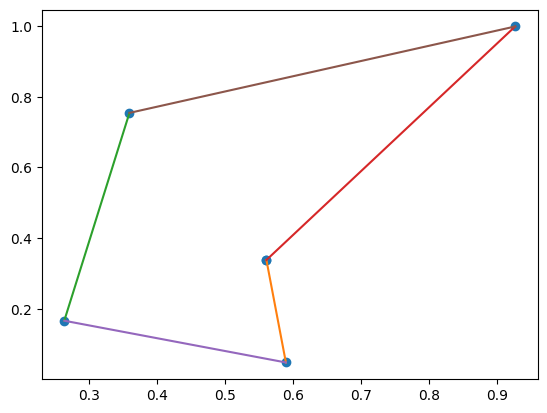

La distancia recorrida por el camino es:  2606.0
el tiempo de ejecución es de:  8.308130979537964


In [262]:
# Dibujamos el camino de la solución
print("Grafo solución")
plt.plot(puntos[:,0],puntos[:,1],'o')
vaux = np.array(list(range(N+1)))
for i in range(N+1):
    sigAux = matSol[i,:]==1
    if np.sum(sigAux) > 0:
        sig = (int(vaux[sigAux][0]))%(N)
        plt.plot(puntos[(i,sig),0],puntos[(i,sig),1])
plt.show()
print("La distancia recorrida por el camino es: ", distanciaSol)
print("el tiempo de ejecución es de: ", time)

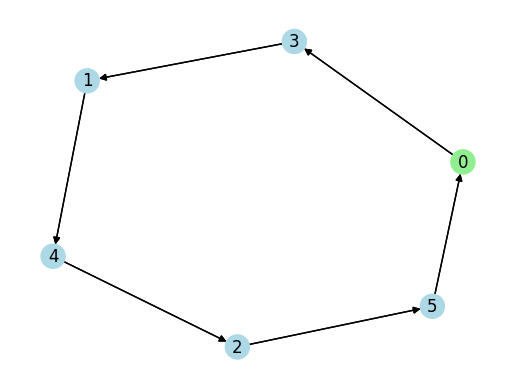

In [269]:
import numpy as np
import networkx as nx

G = nx.DiGraph()
rows, cols = np.where(matSol == 1)
edges = list(zip(rows.tolist(), cols.tolist()))
edges2 = [(x[0], x[1]%len(puntos)) for x in edges]

G.add_edges_from(edges2)
pos2 = nx.spring_layout(G)
nx.draw_networkx_labels(G, pos2)


nx.draw_networkx_edges(G, pos2)

node_colors = ["lightblue" for _ in range(len(G.nodes))]
node_colors[0] = "lightgreen"

nx.draw(G, pos2, node_color = node_colors)
plt.show()